# Physics experiments with $\texttt{LieDetect}$

Henrique Hennes https://github.com/HLovisiEnnes \
Raphaël Tinarrage https://raphaeltinarrage.github.io/

See the repo at https://github.com/HLovisiEnnes/LieDetect and the article at https://arxiv.org/abs/2309.03086

- **I. Three-body problem:** Broucke orbits
- **II. Hamiltonian systems:** Multidimensional harmonic oscillator

In [1]:
# Import LieDetect functions
from functions_20240715 import*

# Import libraries specific to this notebook
import gudhi

2024-07-23 14:06:05.362690: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 14:06:05.367283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-23 14:06:05.367297: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# I. Three-body problem

In [2]:
def ThreeBodyEquation(t, y):
    # Implementation from https://betterprogramming.pub/2-d-three-body-problem-simulation-made-simpler-with-python-40d74217a42a
    f = np.zeros(12)
    f[0] = y[6]; f[1] = y[7]; f[2] = y[8]; f[3] = y[9]; f[4] = y[10]; f[5] = y[11]
    f[6] = -(y[0]-y[2])/(((y[0]-y[2])**2+(y[1]-y[3])**2)**(3/2))-(y[0]-y[4])/(((y[0]-y[4])**2+(y[1]-y[5])**2)**(3/2))
    f[7] = -(y[1]-y[3])/(((y[0]-y[2])**2+(y[1]-y[3])**2)**(3/2))-(y[1]-y[5])/(((y[0]-y[4])**2+(y[1]-y[5])**2)**(3/2))
    f[8] = -(y[2]-y[0])/(((y[2]-y[0])**2+(y[3]-y[1])**2)**(3/2))-(y[2]-y[4])/(((y[2]-y[4])**2+(y[3]-y[5])**2)**(3/2))
    f[9] = -(y[3]-y[1])/(((y[2]-y[0])**2+(y[3]-y[1])**2)**(3/2))-(y[3]-y[5])/(((y[2]-y[4])**2+(y[3]-y[5])**2)**(3/2))
    f[10]= -(y[4]-y[0])/(((y[4]-y[0])**2+(y[5]-y[1])**2)**(3/2))-(y[4]-y[2])/(((y[4]-y[2])**2+(y[5]-y[3])**2)**(3/2))
    f[11]= -(y[5]-y[1])/(((y[4]-y[0])**2+(y[5]-y[1])**2)**(3/2))-(y[5]-y[3])/(((y[4]-y[2])**2+(y[5]-y[3])**2)**(3/2))    
    return f

def MakeDataset(InitialValue, Period, T, N_points_subsample, method_space):
    '''
    method_space='position' embbed the 3 bodies into R^6 by stacking their positions, while
    method_space='position' embbed them into R^{12}, by stacking their positions and velocities
    '''
    # Integrate
    N = int(Period/T)
    t = np.linspace(0,Period,N) # Time is defined between 0 and N*T for N number of samples
    solution = scipy.integrate.solve_ivp(fun = ThreeBodyEquation, t_span = [0,Period], y0 = InitialValue, t_eval = t, 
                                         atol=1e-10, rtol = 1e-10, method='Radau')

    # Generate point cloud
    if method_space=='position':
        X = np.stack((solution.y[0],solution.y[1],solution.y[2],solution.y[3],solution.y[4],solution.y[5])).T
    if method_space=='velocity':
        X = np.stack((solution.y[0],solution.y[1],solution.y[2],solution.y[3],solution.y[4],solution.y[5],
                      solution.y[6],solution.y[7],solution.y[8],solution.y[9],solution.y[10],solution.y[11])).T

    # Subsample with gudhi    
    X = np.array(gudhi.subsampling.choose_n_farthest_points(points=X, nb_points = N_points_subsample))

    # Compute integration error (norm between first and last point --- they should be equal)
    integration_error = np.linalg.norm(solution.y[:,0] - solution.y[:,-1])
    print('Integration error (distance between endpoints):', integration_error)
    
    # Plot the evolution in position with respect to time
    fig = plt.figure(figsize=(6,3)); fig.add_subplot(121); plt.axis('equal');
    plt.plot(solution.y[0],solution.y[1],'-g') #(x1, y1) Planet 1 in green
    plt.plot(solution.y[2],solution.y[3],'-r') #(x2, y2) Planet 2 in red
    plt.plot(solution.y[4],solution.y[5],'-b') #(x3, y3) Planet 3 in blue    
    ax = fig.add_subplot(122,projection='3d')
    Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black', s=5); plt.show();
            
    return X, solution, integration_error

In [3]:
# Found at http://three-body.ipb.ac.rs/broucke.php
Broucke = {
'A1':([-0.9892620043,0.0000000000,2.2096177241,0.0000000000,-1.2203557197,0.0000000000,
      0.0000000000,1.9169244185,0.0000000000,0.1910268738,0.0000000000,-2.1079512924],
     6.283213),
'A2':([0.3361300950,0.0000000000,0.7699893804,0.0000000000,-1.1061194753,0.0000000000,
      0.0000000000,1.5324315370,0.0000000000,-0.6287350978,0.0000000000,-0.9036964391],
     7.702408),
'A3':([0.3149337497,0.0000000000,0.8123820710,0.0000000000,-1.1273158206,0.0000000000,
      0.0000000000,1.4601869417,0.0000000000,-0.5628292375,0.0000000000,-0.8973577042],
     7.910268),
'A7':([-0.1095519101,0.0000000000,1.6613533905,0.0000000000,-1.5518014804,0.0000000000,
      0.0000000000,0.9913358338,0.0000000000,-0.1569959746,0.0000000000,-0.8343398592],
     12.055859),
'A11':([0.0132604844,0.0000000000,1.4157286016,0.0000000000,-1.4289890859,0.0000000000,
      0.0000000000,1.0541519210,0.0000000000,-0.2101466639,0.0000000000,-0.8440052572],
     32.584945),
'R1':([0.8083106230,0.0000000000,-0.4954148566,0.0000000000,-0.3128957664,0.0000000000,
      0.0000000000,0.9901979166,0.0000000000,-2.7171431768,0.0000000000,1.7269452602],
     5.226525),
'R2':([0.9060893715,0.0000000000,-0.6909723536,0.0000000000,-0.2151170179,0.0000000000,
      0.0000000000,0.9658548899,0.0000000000,-1.6223214842,0.0000000000,0.6564665942],
     5.704198),
'R8':([0.8871256555,0.0000000000,-0.6530449215,0.0000000000,-0.2340807340,0.0000000000,
      0.0000000000,0.9374933545,0.0000000000,-1.7866975426,0.0000000000,0.8492041880],
     11.224844),
'R9':([0.9015586070,0.0000000000,-0.6819108246,0.0000000000,-0.2196477824,0.0000000000,
      0.0000000000,0.9840575737,0.0000000000,-1.6015183264,0.0000000000,0.6174607527],
     11.295591),
'R11':([0.8983487470,0.0000000000,-0.6754911045,0.0000000000,-0.2228576425,0.0000000000,
      0.0000000000,0.9475564971,0.0000000000,-1.7005860354,0.0000000000,0.7530295383],
     17.021765),
'R12':([0.9040866398,0.0000000000,-0.6869668901,0.0000000000,-0.2171197497,0.0000000000,
     0.0000000000,0.9789534005,0.0000000000,-1.6017790202,0.0000000000,0.6228256196],
     17.020603),
'R13':([0.9017748598,0.0000000000,-0.6823433302,0.0000000000,-0.2194315296,0.0000000000,
      0.0000000000,0.9526089117,0.0000000000,-1.6721104565,0.0000000000,0.7195015448],
     22.764421)}

Scores = []

Integration error (distance between endpoints): 0.0007381991544656458


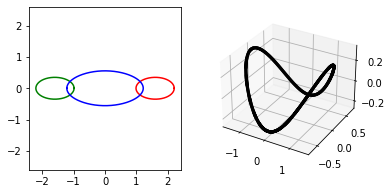

Covariance eigenvalues: [0.848, 0.114, 0.035, 0.002, 0.0, 0.0]


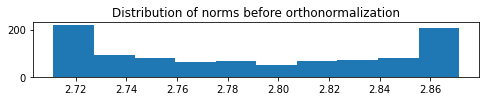

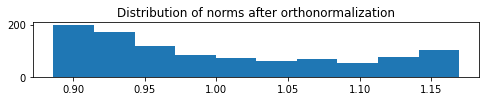

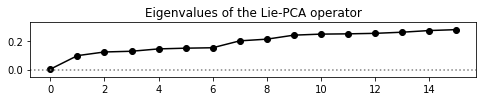

Optimal frequencies found: ((1, 2),)
Symmetric Hausdorff distance: 0.18116


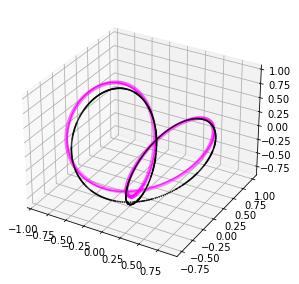

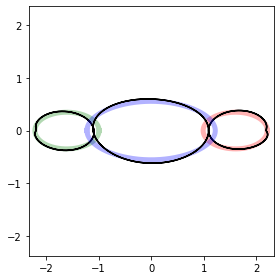

In [4]:
# Generate dataset
name = 'A1'
T, N_points_subsample = 0.001, 1000
InitialValue, Period = Broucke[name]
X, solution, integration_error = MakeDataset(InitialValue=InitialValue,Period=Period,T=T,N_points_subsample=N_points_subsample,method_space='position')
PrintCovarianceEigenvalues(X)
PlotNormsDistribution(X); plt.title('Distribution of norms before orthonormalization');

# Reduce dimension and orthonormalize
ambient_dim = 4
pca = sklearn.decomposition.PCA(n_components=ambient_dim)
Y = pca.fit_transform(X)
Y, Cov = Orthonormalize(Y)
PlotNormsDistribution(Y); plt.title('Distribution of norms after orthonormalization');

# Lie-PCA
Sigma = GetLiePCAOperator(Y,n_neighbors=2,dim=1,method='localPCA',verbose=0)
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

# LieDetect
frequency_max = 8
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group='torus', Sigma=Sigma, dim=1, ambient_dim=ambient_dim,
                                                              frequency_max=frequency_max, method='NormalForm', verbosity=0)            
print('Optimal frequencies found:', OptimalFrequencies)
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=N_points_subsample, x=Y[0,:], method='uniform')
print('Symmetric Hausdorff distance:', round(max(scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0],scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]),5))

# Plot estimated orbit
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
pca_Y = sklearn.decomposition.PCA(n_components=3).fit(Y)
Ypca = pca_Y.transform(Y); ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=0.5);
Orbitpca = pca_Y.transform(Orbit); ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.8, alpha=0.5,marker="3"); 
plt.tight_layout(); plt.show(); fig.savefig('Figures/Broucke_embedding_'+name+'.png',dpi=fig.dpi,bbox_inches='tight')

# Reconstruct initial orbits and plot
Cov_inv = np.linalg.inv(Cov)
OrbitFull = pca.inverse_transform(np.array([Cov_inv.dot(x) for x in Orbit])) # undo orthonormalization and pca
fig = plt.figure(figsize=(4,4))
plt.plot(solution.y[0],solution.y[1],'-g',lw=5,alpha=0.3); plt.plot(OrbitFull[:,0],OrbitFull[:,1],color='black')
plt.plot(solution.y[2],solution.y[3],'-r',lw=5,alpha=0.3); plt.plot(OrbitFull[:,2],OrbitFull[:,3],color='black')
plt.plot(solution.y[4],solution.y[5],'-b',lw=5,alpha=0.3); plt.plot(OrbitFull[:,4],OrbitFull[:,5],color='black')
plt.axis('equal'); plt.tight_layout(); plt.show(); fig.savefig('Figures/Broucke_orbit_'+name+'.png',dpi=fig.dpi,bbox_inches='tight');

# Save scores
Hausdorff0 = max(scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0],scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0])
Hausdorff1 = max(scipy.spatial.distance.directed_hausdorff(X[:,0:2], OrbitFull[:,0:2])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,0:2], X[:,0:2])[0])
Hausdorff2 = max(scipy.spatial.distance.directed_hausdorff(X[:,2:4], OrbitFull[:,2:4])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,2:4], X[:,2:4])[0])
Hausdorff3 = max(scipy.spatial.distance.directed_hausdorff(X[:,4:6], OrbitFull[:,4:6])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,4:6], X[:,4:6])[0])
msg = name+' & \\begin{minipage}{.3\\linewidth}\\vspace{1mm}\\includegraphics[width=1\\linewidth]{Broucke_orbit_'+name+'.png}\\vspace{1mm}\\end{minipage} & \\begin{minipage}{.3\linewidth}\\vspace{1mm}\\includegraphics[width=1\\linewidth]{Broucke_embedding_'+name+'.png}\\vspace{1mm}\\end{minipage} & $'+str(OptimalFrequencies[0])+'$ & \\begin{tabular}{@{}c@{}}\\textcolor{dartmouthgreen}{'+str(round(Hausdorff1,5))+'} \\\\ \\textcolor{red}{'+str(round(Hausdorff2,5))+'}\\\\ \\textcolor{blue}{'+str(round(Hausdorff3,5))+'} \\\ \\textcolor{deepmagenta}{'+str(round(Hausdorff0,5))+'}\\end{tabular}\\\\\\hline'
Scores.append(msg)

Integration error (distance between endpoints): 0.001869025670120853


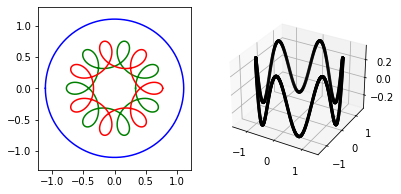

Covariance eigenvalues: [0.476, 0.475, 0.025, 0.025, -0.0, -0.0]


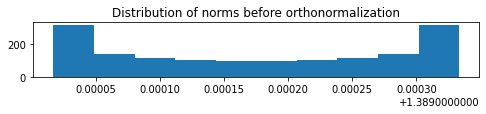

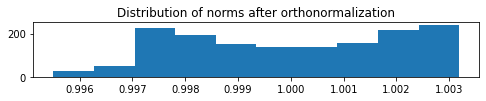

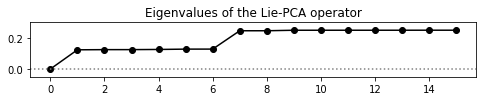

Optimal frequencies found: ((1, 6),)
Symmetric Hausdorff distance: 0.01122


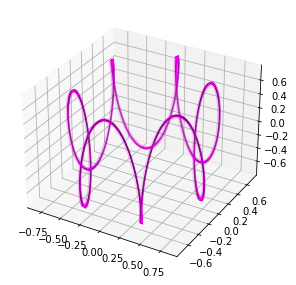

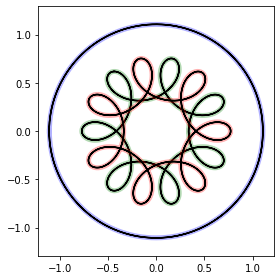

In [5]:
# Generate dataset
name = 'A2'
T, N_points_subsample = 0.005, 5000
InitialValue, Period = Broucke[name]
X, solution, integration_error = MakeDataset(InitialValue=InitialValue,Period=Period,T=T,N_points_subsample=N_points_subsample,method_space='position')
PrintCovarianceEigenvalues(X)
PlotNormsDistribution(X); plt.title('Distribution of norms before orthonormalization');

# Reduce dimension and orthonormalize
ambient_dim = 4
pca = sklearn.decomposition.PCA(n_components=ambient_dim)
Y = pca.fit_transform(X)
Y, Cov = Orthonormalize(Y)
PlotNormsDistribution(Y); plt.title('Distribution of norms after orthonormalization');

# Lie-PCA
Sigma = GetLiePCAOperator(Y,n_neighbors=2,dim=1,method='localPCA',verbose=0)
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

# LieDetect
frequency_max = 10
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group='torus', Sigma=Sigma, dim=1, ambient_dim=ambient_dim,
                                                              frequency_max=frequency_max, method='NormalForm', verbosity=0)            
print('Optimal frequencies found:', OptimalFrequencies)
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=N_points_subsample, x=Y[0,:], method='uniform')
print('Symmetric Hausdorff distance:', round(max(scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0],scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]),5))

# Plot estimated orbit
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
pca_Y = sklearn.decomposition.PCA(n_components=3).fit(Y)
Ypca = pca_Y.transform(Y); ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=0.5);
Orbitpca = pca_Y.transform(Orbit); ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.8, alpha=0.1,marker="3"); 
plt.tight_layout(); plt.show(); fig.savefig('Figures/Broucke_embedding_'+name+'.png',dpi=fig.dpi,bbox_inches='tight')

# Reconstruct initial orbits and plot
Cov_inv = np.linalg.inv(Cov)
OrbitFull = pca.inverse_transform(np.array([Cov_inv.dot(x) for x in Orbit])) # undo orthonormalization and pca
fig = plt.figure(figsize=(4,4))
plt.plot(solution.y[0],solution.y[1],'-g',lw=5,alpha=0.3); plt.plot(OrbitFull[:,0],OrbitFull[:,1],color='black')
plt.plot(solution.y[2],solution.y[3],'-r',lw=5,alpha=0.3); plt.plot(OrbitFull[:,2],OrbitFull[:,3],color='black')
plt.plot(solution.y[4],solution.y[5],'-b',lw=5,alpha=0.3); plt.plot(OrbitFull[:,4],OrbitFull[:,5],color='black')
plt.axis('equal'); plt.tight_layout(); plt.show(); fig.savefig('Figures/Broucke_orbit_'+name+'.png',dpi=fig.dpi,bbox_inches='tight');

# Save scores
Hausdorff0 = max(scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0],scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0])
Hausdorff1 = max(scipy.spatial.distance.directed_hausdorff(X[:,0:2], OrbitFull[:,0:2])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,0:2], X[:,0:2])[0])
Hausdorff2 = max(scipy.spatial.distance.directed_hausdorff(X[:,2:4], OrbitFull[:,2:4])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,2:4], X[:,2:4])[0])
Hausdorff3 = max(scipy.spatial.distance.directed_hausdorff(X[:,4:6], OrbitFull[:,4:6])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,4:6], X[:,4:6])[0])
msg = name+' & \\begin{minipage}{.3\\linewidth}\\vspace{1mm}\\includegraphics[width=1\\linewidth]{Broucke_orbit_'+name+'.png}\\vspace{1mm}\\end{minipage} & \\begin{minipage}{.3\linewidth}\\vspace{1mm}\\includegraphics[width=1\\linewidth]{Broucke_embedding_'+name+'.png}\\vspace{1mm}\\end{minipage} & $'+str(OptimalFrequencies[0])+'$ & \\begin{tabular}{@{}c@{}}\\textcolor{dartmouthgreen}{'+str(round(Hausdorff1,5))+'} \\\\ \\textcolor{red}{'+str(round(Hausdorff2,5))+'}\\\\ \\textcolor{blue}{'+str(round(Hausdorff3,5))+'} \\\ \\textcolor{deepmagenta}{'+str(round(Hausdorff0,5))+'}\\end{tabular}\\\\\\hline'
Scores.append(msg)

Integration error (distance between endpoints): 0.0005262003285506164


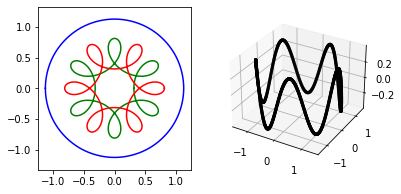

Covariance eigenvalues: [0.469, 0.469, 0.031, 0.031, 0.0, 0.0]


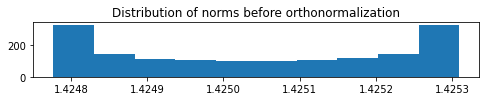

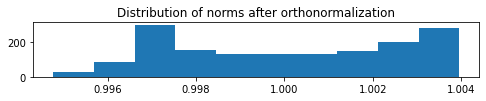

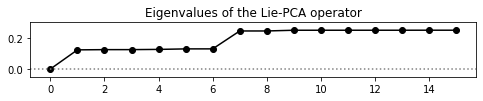

Optimal frequencies found: ((1, 5),)
Symmetric Hausdorff distance: 0.00982


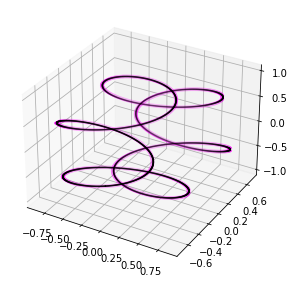

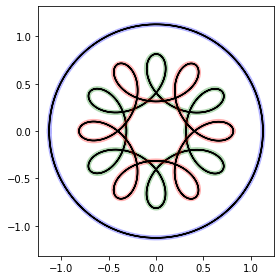

In [6]:
# Generate dataset
name = 'A3'
T, N_points_subsample = 0.005, 5000
InitialValue, Period = Broucke[name]
X, solution, integration_error = MakeDataset(InitialValue=InitialValue,Period=Period,T=T,N_points_subsample=N_points_subsample,method_space='position')
PrintCovarianceEigenvalues(X)
PlotNormsDistribution(X); plt.title('Distribution of norms before orthonormalization');

# Reduce dimension and orthonormalize
ambient_dim = 4
pca = sklearn.decomposition.PCA(n_components=ambient_dim)
Y = pca.fit_transform(X)
Y, Cov = Orthonormalize(Y)
PlotNormsDistribution(Y); plt.title('Distribution of norms after orthonormalization');

# Lie-PCA
Sigma = GetLiePCAOperator(Y,n_neighbors=2,dim=1,method='localPCA',verbose=0)
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

# LieDetect
frequency_max = 10
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group='torus', Sigma=Sigma, dim=1, ambient_dim=ambient_dim,
                                                              frequency_max=frequency_max, method='NormalForm', verbosity=0)            
print('Optimal frequencies found:', OptimalFrequencies)
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=N_points_subsample, x=Y[0,:], method='uniform')
print('Symmetric Hausdorff distance:', round(max(scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0],scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]),5))

# Plot estimated orbit
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
pca_Y = sklearn.decomposition.PCA(n_components=3).fit(Y)
Ypca = pca_Y.transform(Y); ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=0.5);
Orbitpca = pca_Y.transform(Orbit); ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.8, alpha=0.1,marker="3"); 
plt.tight_layout(); plt.show(); fig.savefig('Figures/Broucke_embedding_'+name+'.png',dpi=fig.dpi,bbox_inches='tight')

# Reconstruct initial orbits and plot
Cov_inv = np.linalg.inv(Cov)
OrbitFull = pca.inverse_transform(np.array([Cov_inv.dot(x) for x in Orbit])) # undo orthonormalization and pca
fig = plt.figure(figsize=(4,4))
plt.plot(solution.y[0],solution.y[1],'-g',lw=5,alpha=0.3); plt.plot(OrbitFull[:,0],OrbitFull[:,1],color='black')
plt.plot(solution.y[2],solution.y[3],'-r',lw=5,alpha=0.3); plt.plot(OrbitFull[:,2],OrbitFull[:,3],color='black')
plt.plot(solution.y[4],solution.y[5],'-b',lw=5,alpha=0.3); plt.plot(OrbitFull[:,4],OrbitFull[:,5],color='black')
plt.axis('equal'); plt.tight_layout(); plt.show(); fig.savefig('Figures/Broucke_orbit_'+name+'.png',dpi=fig.dpi,bbox_inches='tight');

# Save scores
Hausdorff0 = max(scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0],scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0])
Hausdorff1 = max(scipy.spatial.distance.directed_hausdorff(X[:,0:2], OrbitFull[:,0:2])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,0:2], X[:,0:2])[0])
Hausdorff2 = max(scipy.spatial.distance.directed_hausdorff(X[:,2:4], OrbitFull[:,2:4])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,2:4], X[:,2:4])[0])
Hausdorff3 = max(scipy.spatial.distance.directed_hausdorff(X[:,4:6], OrbitFull[:,4:6])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,4:6], X[:,4:6])[0])
msg = name+' & \\begin{minipage}{.3\\linewidth}\\vspace{1mm}\\includegraphics[width=1\\linewidth]{Broucke_orbit_'+name+'.png}\\vspace{1mm}\\end{minipage} & \\begin{minipage}{.3\linewidth}\\vspace{1mm}\\includegraphics[width=1\\linewidth]{Broucke_embedding_'+name+'.png}\\vspace{1mm}\\end{minipage} & $'+str(OptimalFrequencies[0])+'$ & \\begin{tabular}{@{}c@{}}\\textcolor{dartmouthgreen}{'+str(round(Hausdorff1,5))+'} \\\\ \\textcolor{red}{'+str(round(Hausdorff2,5))+'}\\\\ \\textcolor{blue}{'+str(round(Hausdorff3,5))+'} \\\ \\textcolor{deepmagenta}{'+str(round(Hausdorff0,5))+'}\\end{tabular}\\\\\\hline'
Scores.append(msg)

Integration error (distance between endpoints): 0.0006117338087801804


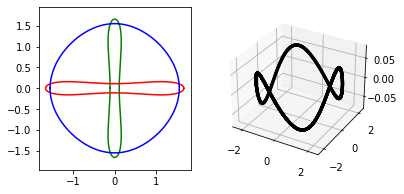

Covariance eigenvalues: [0.5, 0.499, 0.0, 0.0, 0.0, 0.0]


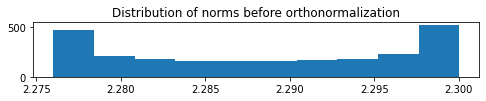

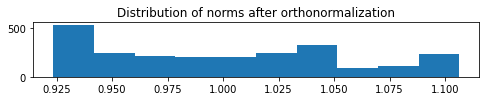

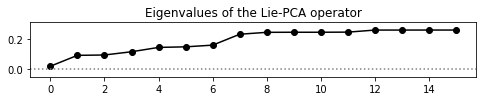

Optimal frequencies found: ((1, 3),)
Symmetric Hausdorff distance: 0.18344


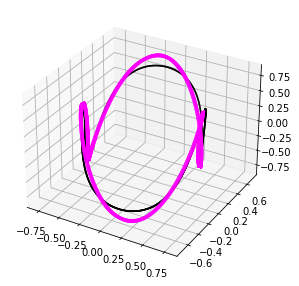

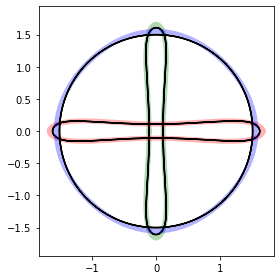

In [7]:
# Generate dataset
name = 'A7'
T, N_points_subsample = 0.005, 5000
InitialValue, Period = Broucke[name]
X, solution, integration_error = MakeDataset(InitialValue=InitialValue,Period=Period,T=T,N_points_subsample=N_points_subsample,method_space='position')
PrintCovarianceEigenvalues(X)
PlotNormsDistribution(X); plt.title('Distribution of norms before orthonormalization');

# Reduce dimension and orthonormalize
ambient_dim = 4
pca = sklearn.decomposition.PCA(n_components=ambient_dim)
Y = pca.fit_transform(X)
Y, Cov = Orthonormalize(Y)
PlotNormsDistribution(Y); plt.title('Distribution of norms after orthonormalization');

# Lie-PCA
Sigma = GetLiePCAOperator(Y,n_neighbors=2,dim=1,method='localPCA',verbose=0)
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

# LieDetect
frequency_max = 10
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group='torus', Sigma=Sigma, dim=1, ambient_dim=ambient_dim,
                                                              frequency_max=frequency_max, method='NormalForm', verbosity=0)            
print('Optimal frequencies found:', OptimalFrequencies)
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=N_points_subsample, x=Y[0,:], method='uniform')
print('Symmetric Hausdorff distance:', round(max(scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0],scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]),5))

# Plot estimated orbit
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
pca_Y = sklearn.decomposition.PCA(n_components=3).fit(Y)
Ypca = pca_Y.transform(Y); ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=0.5);
Orbitpca = pca_Y.transform(Orbit); ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.8, alpha=0.5,marker="3"); 
plt.tight_layout(); plt.show(); fig.savefig('Figures/Broucke_embedding_'+name+'.png',dpi=fig.dpi,bbox_inches='tight')

# Reconstruct initial orbits and plot
Cov_inv = np.linalg.inv(Cov)
OrbitFull = pca.inverse_transform(np.array([Cov_inv.dot(x) for x in Orbit])) # undo orthonormalization and pca
fig = plt.figure(figsize=(4,4))
plt.plot(solution.y[0],solution.y[1],'-g',lw=5,alpha=0.3); plt.plot(OrbitFull[:,0],OrbitFull[:,1],color='black')
plt.plot(solution.y[2],solution.y[3],'-r',lw=5,alpha=0.3); plt.plot(OrbitFull[:,2],OrbitFull[:,3],color='black')
plt.plot(solution.y[4],solution.y[5],'-b',lw=5,alpha=0.3); plt.plot(OrbitFull[:,4],OrbitFull[:,5],color='black')
plt.axis('equal'); plt.tight_layout(); plt.show(); fig.savefig('Figures/Broucke_orbit_'+name+'.png',dpi=fig.dpi,bbox_inches='tight');

# Save scores
Hausdorff0 = max(scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0],scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0])
Hausdorff1 = max(scipy.spatial.distance.directed_hausdorff(X[:,0:2], OrbitFull[:,0:2])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,0:2], X[:,0:2])[0])
Hausdorff2 = max(scipy.spatial.distance.directed_hausdorff(X[:,2:4], OrbitFull[:,2:4])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,2:4], X[:,2:4])[0])
Hausdorff3 = max(scipy.spatial.distance.directed_hausdorff(X[:,4:6], OrbitFull[:,4:6])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,4:6], X[:,4:6])[0])
msg = name+' & \\begin{minipage}{.3\\linewidth}\\vspace{1mm}\\includegraphics[width=1\\linewidth]{Broucke_orbit_'+name+'.png}\\vspace{1mm}\\end{minipage} & \\begin{minipage}{.3\linewidth}\\vspace{1mm}\\includegraphics[width=1\\linewidth]{Broucke_embedding_'+name+'.png}\\vspace{1mm}\\end{minipage} & $'+str(OptimalFrequencies[0])+'$ & \\begin{tabular}{@{}c@{}}\\textcolor{dartmouthgreen}{'+str(round(Hausdorff1,5))+'} \\\\ \\textcolor{red}{'+str(round(Hausdorff2,5))+'}\\\\ \\textcolor{blue}{'+str(round(Hausdorff3,5))+'} \\\ \\textcolor{deepmagenta}{'+str(round(Hausdorff0,5))+'}\\end{tabular}\\\\\\hline'
Scores.append(msg)

Integration error (distance between endpoints): 0.0003392670287893733


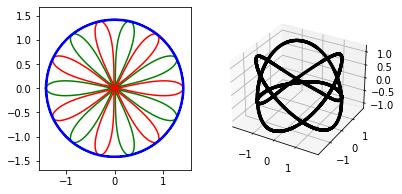

Covariance eigenvalues: [0.372, 0.371, 0.129, 0.129, 0.0, -0.0]


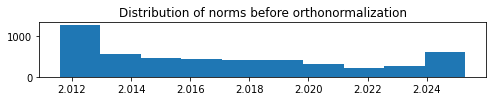

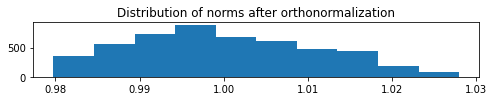

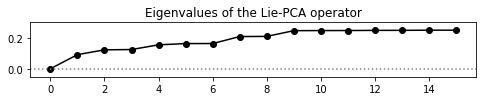

Optimal frequencies found: ((3, 4),)
Symmetric Hausdorff distance: 0.04789


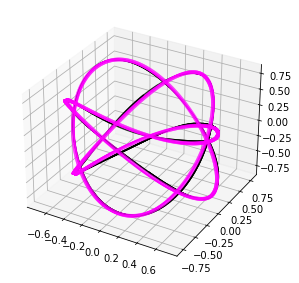

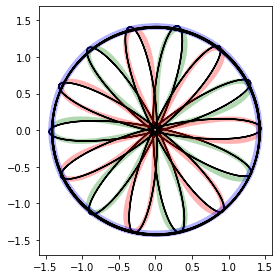

In [8]:
# Generate dataset
name = 'A11'
T, N_points_subsample = 0.005, 5000
InitialValue, Period = Broucke[name]
X, solution, integration_error = MakeDataset(InitialValue=InitialValue,Period=Period,T=T,N_points_subsample=N_points_subsample,method_space='position')
PrintCovarianceEigenvalues(X)
PlotNormsDistribution(X); plt.title('Distribution of norms before orthonormalization');

# Reduce dimension and orthonormalize
ambient_dim = 4
pca = sklearn.decomposition.PCA(n_components=ambient_dim)
Y = pca.fit_transform(X)
Y, Cov = Orthonormalize(Y)
PlotNormsDistribution(Y); plt.title('Distribution of norms after orthonormalization');

# Lie-PCA
Sigma = GetLiePCAOperator(Y,n_neighbors=2,dim=1,method='localPCA',verbose=0)
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

# LieDetect
frequency_max = 10
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group='torus', Sigma=Sigma, dim=1, ambient_dim=ambient_dim,
                                                              frequency_max=frequency_max, method='NormalForm', verbosity=0)            
print('Optimal frequencies found:', OptimalFrequencies)
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=N_points_subsample, x=Y[0,:], method='uniform')
print('Symmetric Hausdorff distance:', round(max(scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0],scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]),5))

# Plot estimated orbit
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
pca_Y = sklearn.decomposition.PCA(n_components=3).fit(Y)
Ypca = pca_Y.transform(Y); ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=0.5);
Orbitpca = pca_Y.transform(Orbit); ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.8, alpha=0.5,marker="3"); 
plt.tight_layout(); plt.show(); fig.savefig('Figures/Broucke_embedding_'+name+'.png',dpi=fig.dpi,bbox_inches='tight')

# Reconstruct initial orbits and plot
Cov_inv = np.linalg.inv(Cov)
OrbitFull = pca.inverse_transform(np.array([Cov_inv.dot(x) for x in Orbit])) # undo orthonormalization and pca
fig = plt.figure(figsize=(4,4))
plt.plot(solution.y[0],solution.y[1],'-g',lw=5,alpha=0.3); plt.plot(OrbitFull[:,0],OrbitFull[:,1],color='black')
plt.plot(solution.y[2],solution.y[3],'-r',lw=5,alpha=0.3); plt.plot(OrbitFull[:,2],OrbitFull[:,3],color='black')
plt.plot(solution.y[4],solution.y[5],'-b',lw=5,alpha=0.3); plt.plot(OrbitFull[:,4],OrbitFull[:,5],color='black')
plt.axis('equal'); plt.tight_layout(); plt.show(); fig.savefig('Figures/Broucke_orbit_'+name+'.png',dpi=fig.dpi,bbox_inches='tight');

# Save scores
Hausdorff0 = max(scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0],scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0])
Hausdorff1 = max(scipy.spatial.distance.directed_hausdorff(X[:,0:2], OrbitFull[:,0:2])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,0:2], X[:,0:2])[0])
Hausdorff2 = max(scipy.spatial.distance.directed_hausdorff(X[:,2:4], OrbitFull[:,2:4])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,2:4], X[:,2:4])[0])
Hausdorff3 = max(scipy.spatial.distance.directed_hausdorff(X[:,4:6], OrbitFull[:,4:6])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,4:6], X[:,4:6])[0])
msg = name+' & \\begin{minipage}{.3\\linewidth}\\vspace{1mm}\\includegraphics[width=1\\linewidth]{Broucke_orbit_'+name+'.png}\\vspace{1mm}\\end{minipage} & \\begin{minipage}{.3\linewidth}\\vspace{1mm}\\includegraphics[width=1\\linewidth]{Broucke_embedding_'+name+'.png}\\vspace{1mm}\\end{minipage} & $'+str(OptimalFrequencies[0])+'$ & \\begin{tabular}{@{}c@{}}\\textcolor{dartmouthgreen}{'+str(round(Hausdorff1,5))+'} \\\\ \\textcolor{red}{'+str(round(Hausdorff2,5))+'}\\\\ \\textcolor{blue}{'+str(round(Hausdorff3,5))+'} \\\ \\textcolor{deepmagenta}{'+str(round(Hausdorff0,5))+'}\\end{tabular}\\\\\\hline'
Scores.append(msg)

Integration error (distance between endpoints): 0.0014144195116654076


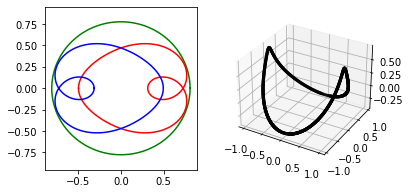

Covariance eigenvalues: [0.343, 0.313, 0.292, 0.053, 0.0, -0.0]


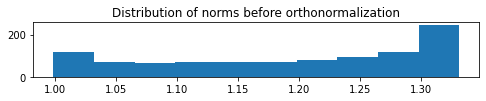

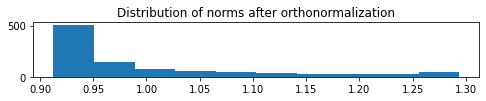

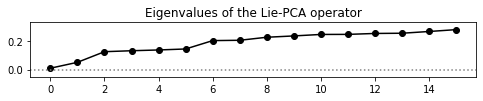

Optimal frequencies found: ((1, 2),)
Symmetric Hausdorff distance: 0.43316


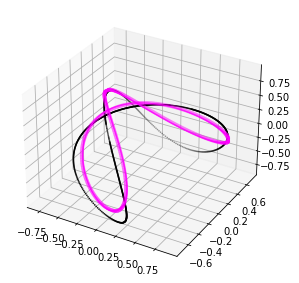

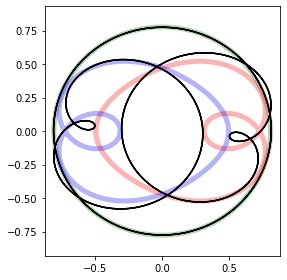

In [9]:
# Generate dataset
name = 'R1'
T, N_points_subsample = 0.005, 1000
InitialValue, Period = Broucke[name]
X, solution, integration_error = MakeDataset(InitialValue=InitialValue,Period=Period,T=T,N_points_subsample=N_points_subsample,method_space='position')
PrintCovarianceEigenvalues(X)
PlotNormsDistribution(X); plt.title('Distribution of norms before orthonormalization');

# Reduce dimension and orthonormalize
ambient_dim = 4
pca = sklearn.decomposition.PCA(n_components=ambient_dim)
Y = pca.fit_transform(X)
Y, Cov = Orthonormalize(Y)
PlotNormsDistribution(Y); plt.title('Distribution of norms after orthonormalization');

# Lie-PCA
Sigma = GetLiePCAOperator(Y,n_neighbors=2,dim=1,method='localPCA',verbose=0)
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

# LieDetect
frequency_max = 6
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group='torus', Sigma=Sigma, dim=1, ambient_dim=ambient_dim,
                                                              frequency_max=frequency_max, method='NormalForm', verbosity=0)            
print('Optimal frequencies found:', OptimalFrequencies)
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=N_points_subsample, x=Y[0,:], method='uniform')
print('Symmetric Hausdorff distance:', round(max(scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0],scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]),5))

# Plot estimated orbit
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
pca_Y = sklearn.decomposition.PCA(n_components=3).fit(Y)
Ypca = pca_Y.transform(Y); ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=0.5);
Orbitpca = pca_Y.transform(Orbit); ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.8, alpha=0.5,marker="3"); 
plt.tight_layout(); plt.show(); fig.savefig('Figures/Broucke_embedding_'+name+'.png',dpi=fig.dpi,bbox_inches='tight')

# Reconstruct initial orbits and plot
Cov_inv = np.linalg.inv(Cov)
OrbitFull = pca.inverse_transform(np.array([Cov_inv.dot(x) for x in Orbit])) # undo orthonormalization and pca
fig = plt.figure(figsize=(4,4))
plt.plot(solution.y[0],solution.y[1],'-g',lw=5,alpha=0.3); plt.plot(OrbitFull[:,0],OrbitFull[:,1],color='black')
plt.plot(solution.y[2],solution.y[3],'-r',lw=5,alpha=0.3); plt.plot(OrbitFull[:,2],OrbitFull[:,3],color='black')
plt.plot(solution.y[4],solution.y[5],'-b',lw=5,alpha=0.3); plt.plot(OrbitFull[:,4],OrbitFull[:,5],color='black')
plt.axis('equal'); plt.tight_layout(); plt.show(); fig.savefig('Figures/Broucke_orbit_'+name+'.png',dpi=fig.dpi,bbox_inches='tight');

# Save scores
Hausdorff0 = max(scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0],scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0])
Hausdorff1 = max(scipy.spatial.distance.directed_hausdorff(X[:,0:2], OrbitFull[:,0:2])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,0:2], X[:,0:2])[0])
Hausdorff2 = max(scipy.spatial.distance.directed_hausdorff(X[:,2:4], OrbitFull[:,2:4])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,2:4], X[:,2:4])[0])
Hausdorff3 = max(scipy.spatial.distance.directed_hausdorff(X[:,4:6], OrbitFull[:,4:6])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,4:6], X[:,4:6])[0])
msg = name+' & \\begin{minipage}{.3\\linewidth}\\vspace{1mm}\\includegraphics[width=1\\linewidth]{Broucke_orbit_'+name+'.png}\\vspace{1mm}\\end{minipage} & \\begin{minipage}{.3\linewidth}\\vspace{1mm}\\includegraphics[width=1\\linewidth]{Broucke_embedding_'+name+'.png}\\vspace{1mm}\\end{minipage} & $'+str(OptimalFrequencies[0])+'$ & \\begin{tabular}{@{}c@{}}\\textcolor{dartmouthgreen}{'+str(round(Hausdorff1,5))+'} \\\\ \\textcolor{red}{'+str(round(Hausdorff2,5))+'}\\\\ \\textcolor{blue}{'+str(round(Hausdorff3,5))+'} \\\ \\textcolor{deepmagenta}{'+str(round(Hausdorff0,5))+'}\\end{tabular}\\\\\\hline'
Scores.append(msg)

Integration error (distance between endpoints): 0.0036546030700700264


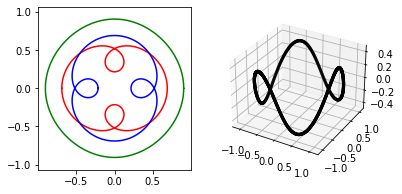

Covariance eigenvalues: [0.443, 0.442, 0.058, 0.058, 0.0, -0.0]


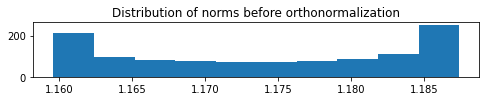

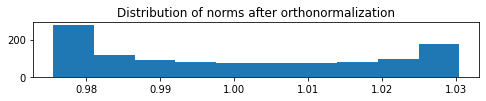

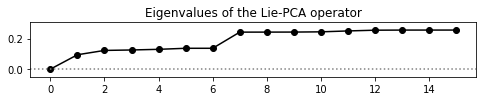

Optimal frequencies found: ((1, 3),)
Symmetric Hausdorff distance: 0.05391


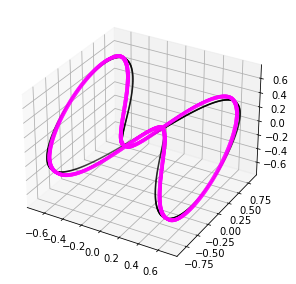

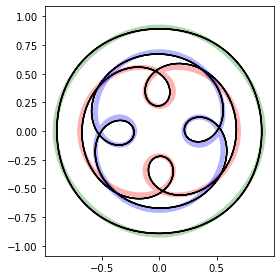

In [10]:
# Generate dataset
name = 'R2'
T, N_points_subsample = 0.005, 5000
InitialValue, Period = Broucke[name]
X, solution, integration_error = MakeDataset(InitialValue=InitialValue,Period=Period,T=T,N_points_subsample=N_points_subsample,method_space='position')
PrintCovarianceEigenvalues(X)
PlotNormsDistribution(X); plt.title('Distribution of norms before orthonormalization');

# Reduce dimension and orthonormalize
ambient_dim = 4
pca = sklearn.decomposition.PCA(n_components=ambient_dim)
Y = pca.fit_transform(X)
Y, Cov = Orthonormalize(Y)
PlotNormsDistribution(Y); plt.title('Distribution of norms after orthonormalization');

# Lie-PCA
Sigma = GetLiePCAOperator(Y,n_neighbors=2,dim=1,method='localPCA',verbose=0)
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

# LieDetect
frequency_max = 10
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group='torus', Sigma=Sigma, dim=1, ambient_dim=ambient_dim,
                                                              frequency_max=frequency_max, method='NormalForm', verbosity=0)            
print('Optimal frequencies found:', OptimalFrequencies)
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=N_points_subsample, x=Y[0,:], method='uniform')
print('Symmetric Hausdorff distance:', round(max(scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0],scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]),5))

# Plot estimated orbit
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
pca_Y = sklearn.decomposition.PCA(n_components=3).fit(Y)
Ypca = pca_Y.transform(Y); ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=0.5);
Orbitpca = pca_Y.transform(Orbit); ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.8, alpha=0.5,marker="3"); 
plt.tight_layout(); plt.show(); fig.savefig('Figures/Broucke_embedding_'+name+'.png',dpi=fig.dpi,bbox_inches='tight')

# Reconstruct initial orbits and plot
Cov_inv = np.linalg.inv(Cov)
OrbitFull = pca.inverse_transform(np.array([Cov_inv.dot(x) for x in Orbit])) # undo orthonormalization and pca
fig = plt.figure(figsize=(4,4))
plt.plot(solution.y[0],solution.y[1],'-g',lw=5,alpha=0.3); plt.plot(OrbitFull[:,0],OrbitFull[:,1],color='black')
plt.plot(solution.y[2],solution.y[3],'-r',lw=5,alpha=0.3); plt.plot(OrbitFull[:,2],OrbitFull[:,3],color='black')
plt.plot(solution.y[4],solution.y[5],'-b',lw=5,alpha=0.3); plt.plot(OrbitFull[:,4],OrbitFull[:,5],color='black')
plt.axis('equal'); plt.tight_layout(); plt.show(); fig.savefig('Figures/Broucke_orbit_'+name+'.png',dpi=fig.dpi,bbox_inches='tight');

# Save scores
Hausdorff0 = max(scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0],scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0])
Hausdorff1 = max(scipy.spatial.distance.directed_hausdorff(X[:,0:2], OrbitFull[:,0:2])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,0:2], X[:,0:2])[0])
Hausdorff2 = max(scipy.spatial.distance.directed_hausdorff(X[:,2:4], OrbitFull[:,2:4])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,2:4], X[:,2:4])[0])
Hausdorff3 = max(scipy.spatial.distance.directed_hausdorff(X[:,4:6], OrbitFull[:,4:6])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,4:6], X[:,4:6])[0])
msg = name+' & \\begin{minipage}{.3\\linewidth}\\vspace{1mm}\\includegraphics[width=1\\linewidth]{Broucke_orbit_'+name+'.png}\\vspace{1mm}\\end{minipage} & \\begin{minipage}{.3\linewidth}\\vspace{1mm}\\includegraphics[width=1\\linewidth]{Broucke_embedding_'+name+'.png}\\vspace{1mm}\\end{minipage} & $'+str(OptimalFrequencies[0])+'$ & \\begin{tabular}{@{}c@{}}\\textcolor{dartmouthgreen}{'+str(round(Hausdorff1,5))+'} \\\\ \\textcolor{red}{'+str(round(Hausdorff2,5))+'}\\\\ \\textcolor{blue}{'+str(round(Hausdorff3,5))+'} \\\ \\textcolor{deepmagenta}{'+str(round(Hausdorff0,5))+'}\\end{tabular}\\\\\\hline'
Scores.append(msg)

Integration error (distance between endpoints): 0.003806286954963457


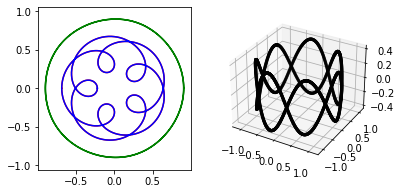

Covariance eigenvalues: [0.452, 0.451, 0.049, 0.049, -0.0, -0.0]


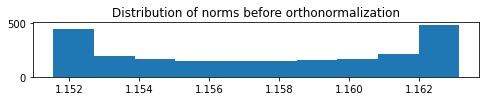

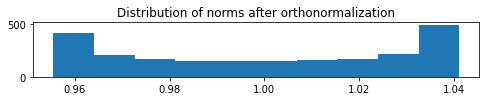

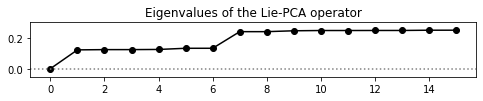

Optimal frequencies found: ((2, 7),)
Symmetric Hausdorff distance: 0.12186


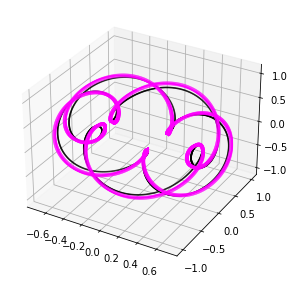

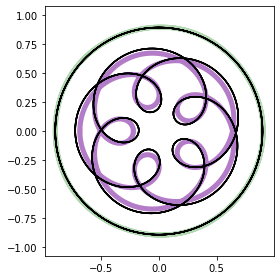

In [11]:
# Generate dataset
name = 'R9'
T, N_points_subsample = 0.005, 5000
InitialValue, Period = Broucke[name]
X, solution, integration_error = MakeDataset(InitialValue=InitialValue,Period=Period,T=T,N_points_subsample=N_points_subsample,method_space='position')
PrintCovarianceEigenvalues(X)
PlotNormsDistribution(X); plt.title('Distribution of norms before orthonormalization');

# Reduce dimension and orthonormalize
ambient_dim = 4
pca = sklearn.decomposition.PCA(n_components=ambient_dim)
Y = pca.fit_transform(X)
Y, Cov = Orthonormalize(Y)
PlotNormsDistribution(Y); plt.title('Distribution of norms after orthonormalization');

# Lie-PCA
Sigma = GetLiePCAOperator(Y,n_neighbors=2,dim=1,method='localPCA',verbose=0)
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

# LieDetect
frequency_max = 10
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group='torus', Sigma=Sigma, dim=1, ambient_dim=ambient_dim,
                                                              frequency_max=frequency_max, method='NormalForm', verbosity=0)            
print('Optimal frequencies found:', OptimalFrequencies)
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=N_points_subsample, x=Y[0,:], method='uniform')
print('Symmetric Hausdorff distance:', round(max(scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0],scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]),5))

# Plot estimated orbit
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
pca_Y = sklearn.decomposition.PCA(n_components=3).fit(Y)
Ypca = pca_Y.transform(Y); ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=0.5);
Orbitpca = pca_Y.transform(Orbit); ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.8, alpha=0.5,marker="3"); 
plt.tight_layout(); plt.show(); fig.savefig('Figures/Broucke_embedding_'+name+'.png',dpi=fig.dpi,bbox_inches='tight')

# Reconstruct initial orbits and plot
Cov_inv = np.linalg.inv(Cov)
OrbitFull = pca.inverse_transform(np.array([Cov_inv.dot(x) for x in Orbit])) # undo orthonormalization and pca
fig = plt.figure(figsize=(4,4))
plt.plot(solution.y[0],solution.y[1],'-g',lw=5,alpha=0.3); plt.plot(OrbitFull[:,0],OrbitFull[:,1],color='black')
plt.plot(solution.y[2],solution.y[3],'-r',lw=5,alpha=0.3); plt.plot(OrbitFull[:,2],OrbitFull[:,3],color='black')
plt.plot(solution.y[4],solution.y[5],'-b',lw=5,alpha=0.3); plt.plot(OrbitFull[:,4],OrbitFull[:,5],color='black')
plt.axis('equal'); plt.tight_layout(); plt.show(); fig.savefig('Figures/Broucke_orbit_'+name+'.png',dpi=fig.dpi,bbox_inches='tight');

# Save scores
Hausdorff0 = max(scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0],scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0])
Hausdorff1 = max(scipy.spatial.distance.directed_hausdorff(X[:,0:2], OrbitFull[:,0:2])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,0:2], X[:,0:2])[0])
Hausdorff2 = max(scipy.spatial.distance.directed_hausdorff(X[:,2:4], OrbitFull[:,2:4])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,2:4], X[:,2:4])[0])
Hausdorff3 = max(scipy.spatial.distance.directed_hausdorff(X[:,4:6], OrbitFull[:,4:6])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,4:6], X[:,4:6])[0])
msg = name+' & \\begin{minipage}{.3\\linewidth}\\vspace{1mm}\\includegraphics[width=1\\linewidth]{Broucke_orbit_'+name+'.png}\\vspace{1mm}\\end{minipage} & \\begin{minipage}{.3\linewidth}\\vspace{1mm}\\includegraphics[width=1\\linewidth]{Broucke_embedding_'+name+'.png}\\vspace{1mm}\\end{minipage} & $'+str(OptimalFrequencies[0])+'$ & \\begin{tabular}{@{}c@{}}\\textcolor{dartmouthgreen}{'+str(round(Hausdorff1,5))+'} \\\\ \\textcolor{red}{'+str(round(Hausdorff2,5))+'}\\\\ \\textcolor{blue}{'+str(round(Hausdorff3,5))+'} \\\ \\textcolor{deepmagenta}{'+str(round(Hausdorff0,5))+'}\\end{tabular}\\\\\\hline'
Scores.append(msg)

Integration error (distance between endpoints): 0.0014003299253124801


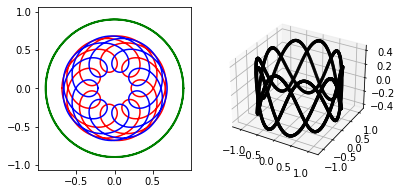

Covariance eigenvalues: [0.448, 0.448, 0.052, 0.052, -0.0, -0.0]


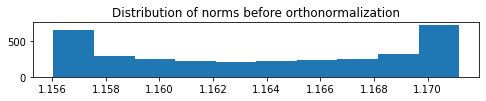

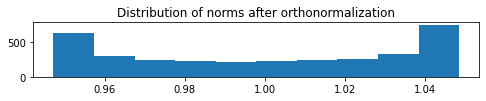

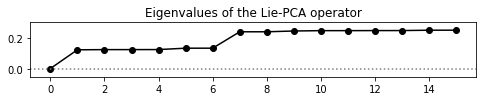

Optimal frequencies found: ((3, 10),)
Symmetric Hausdorff distance: 0.14543


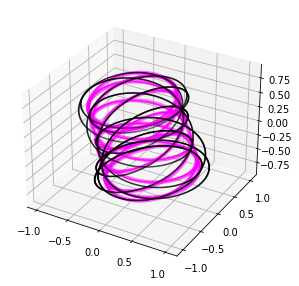

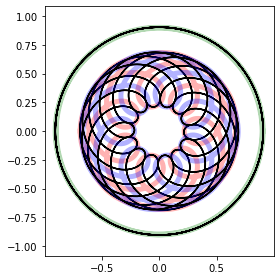

In [12]:
# Generate dataset
name = 'R12'
T, N_points_subsample = 0.005, 5000
InitialValue, Period = Broucke[name]
X, solution, integration_error = MakeDataset(InitialValue=InitialValue,Period=Period,T=T,N_points_subsample=N_points_subsample,method_space='position')
PrintCovarianceEigenvalues(X)
PlotNormsDistribution(X); plt.title('Distribution of norms before orthonormalization');

# Reduce dimension and orthonormalize
ambient_dim = 4
pca = sklearn.decomposition.PCA(n_components=ambient_dim)
Y = pca.fit_transform(X)
Y, Cov = Orthonormalize(Y)
PlotNormsDistribution(Y); plt.title('Distribution of norms after orthonormalization');

# Lie-PCA
Sigma = GetLiePCAOperator(Y,n_neighbors=2,dim=1,method='localPCA',verbose=0)
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

# LieDetect
frequency_max = 10
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group='torus', Sigma=Sigma, dim=1, ambient_dim=ambient_dim,
                                                              frequency_max=frequency_max, method='NormalForm', verbosity=0)            
print('Optimal frequencies found:', OptimalFrequencies)
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=N_points_subsample, x=Y[0,:], method='uniform')
print('Symmetric Hausdorff distance:', round(max(scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0],scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]),5))

# Plot estimated orbit
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
pca_Y = sklearn.decomposition.PCA(n_components=3).fit(Y)
Ypca = pca_Y.transform(Y); ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=0.5);
Orbitpca = pca_Y.transform(Orbit); ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.8, alpha=0.5,marker="3"); 
plt.tight_layout(); plt.show(); fig.savefig('Figures/Broucke_embedding_'+name+'.png',dpi=fig.dpi,bbox_inches='tight')

# Reconstruct initial orbits and plot
Cov_inv = np.linalg.inv(Cov)
OrbitFull = pca.inverse_transform(np.array([Cov_inv.dot(x) for x in Orbit])) # undo orthonormalization and pca
fig = plt.figure(figsize=(4,4))
plt.plot(solution.y[0],solution.y[1],'-g',lw=5,alpha=0.3); plt.plot(OrbitFull[:,0],OrbitFull[:,1],color='black')
plt.plot(solution.y[2],solution.y[3],'-r',lw=5,alpha=0.3); plt.plot(OrbitFull[:,2],OrbitFull[:,3],color='black')
plt.plot(solution.y[4],solution.y[5],'-b',lw=5,alpha=0.3); plt.plot(OrbitFull[:,4],OrbitFull[:,5],color='black')
plt.axis('equal'); plt.tight_layout(); plt.show(); fig.savefig('Figures/Broucke_orbit_'+name+'.png',dpi=fig.dpi,bbox_inches='tight');

# Save scores
Hausdorff0 = max(scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0],scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0])
Hausdorff1 = max(scipy.spatial.distance.directed_hausdorff(X[:,0:2], OrbitFull[:,0:2])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,0:2], X[:,0:2])[0])
Hausdorff2 = max(scipy.spatial.distance.directed_hausdorff(X[:,2:4], OrbitFull[:,2:4])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,2:4], X[:,2:4])[0])
Hausdorff3 = max(scipy.spatial.distance.directed_hausdorff(X[:,4:6], OrbitFull[:,4:6])[0],scipy.spatial.distance.directed_hausdorff(OrbitFull[:,4:6], X[:,4:6])[0])
msg = name+' & \\begin{minipage}{.3\\linewidth}\\vspace{1mm}\\includegraphics[width=1\\linewidth]{Broucke_orbit_'+name+'.png}\\vspace{1mm}\\end{minipage} & \\begin{minipage}{.3\linewidth}\\vspace{1mm}\\includegraphics[width=1\\linewidth]{Broucke_embedding_'+name+'.png}\\vspace{1mm}\\end{minipage} & $'+str(OptimalFrequencies[0])+'$ & \\begin{tabular}{@{}c@{}}\\textcolor{dartmouthgreen}{'+str(round(Hausdorff1,5))+'} \\\\ \\textcolor{red}{'+str(round(Hausdorff2,5))+'}\\\\ \\textcolor{blue}{'+str(round(Hausdorff3,5))+'} \\\ \\textcolor{deepmagenta}{'+str(round(Hausdorff0,5))+'}\\end{tabular}\\\\\\hline'
Scores.append(msg)

In [13]:
' Print latex tabular for article '
print('\n'.join(Scores))
# for score in Scores: print(score[0:-16]+'\\\\\\hline')

A1 & \begin{minipage}{.3\linewidth}\vspace{1mm}\includegraphics[width=1\linewidth]{Broucke_orbit_A1.png}\vspace{1mm}\end{minipage} & \begin{minipage}{.3\linewidth}\vspace{1mm}\includegraphics[width=1\linewidth]{Broucke_embedding_A1.png}\vspace{1mm}\end{minipage} & $(1, 2)$ & \begin{tabular}{@{}c@{}}\textcolor{dartmouthgreen}{0.09782} \\ \textcolor{red}{0.1031}\\ \textcolor{blue}{0.12517} \\ \textcolor{deepmagenta}{0.18116}\end{tabular}\\\hline
A2 & \begin{minipage}{.3\linewidth}\vspace{1mm}\includegraphics[width=1\linewidth]{Broucke_orbit_A2.png}\vspace{1mm}\end{minipage} & \begin{minipage}{.3\linewidth}\vspace{1mm}\includegraphics[width=1\linewidth]{Broucke_embedding_A2.png}\vspace{1mm}\end{minipage} & $(1, 6)$ & \begin{tabular}{@{}c@{}}\textcolor{dartmouthgreen}{0.0041} \\ \textcolor{red}{0.00402}\\ \textcolor{blue}{0.00338} \\ \textcolor{deepmagenta}{0.01122}\end{tabular}\\\hline
A3 & \begin{minipage}{.3\linewidth}\vspace{1mm}\includegraphics[width=1\linewidth]{Broucke_orbit_A3.png}

# II. Hamiltonian systems

In [20]:
def Oscillator(N = 300, k1 = 1, k2 = 2, t_max = 3*2*np.pi, x0 = 1, y0 = 1):
    '''
    Makes data for a simulation of two dimensional harmonic oscillator, 
    with N points, and coeficients k1 and k2. The system is released from (x0,y0)
    '''
    t = np.linspace(0, t_max, N)
    data = np.zeros((N, 4))
    data[:,0] = x0*np.cos(k1*t)
    data[:,1] = -k1*np.sin(k1*t)
    data[:,2] = y0*np.cos(k2*t)
    data[:,3] = -k2*np.sin(k2*t)
    return data

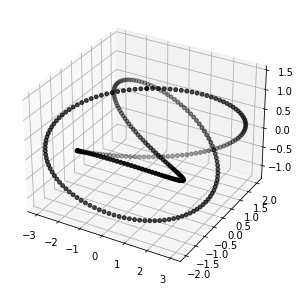

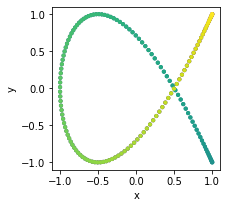

In [21]:
# Makes an oscillator of coefficients k1 = 2 and k2 = 3
X = Oscillator(k1 = 2, k2 = 3)

# Plot point cloud
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black', s=15); plt.show();

# Plot x and y coordinates of the double oscillator
X_plot = Oscillator(k1 = 2, k2 = 3, t_max = 2*np.pi)
fig = plt.figure(figsize=(3,3)); 
plt.scatter(X_plot[:,0], X_plot[:,2], cmap = 'viridis', c = range(len(X)),s=10)
plt.xlabel('x'); plt.ylabel('y');
fig.savefig('Figures/Harmonic_oscillator_1.png',dpi=fig.dpi,bbox_inches='tight');

Covariance eigenvalues: [0.599, 0.266, 0.067, 0.067]


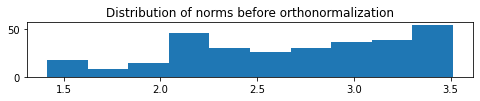

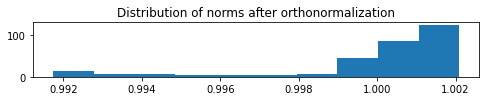

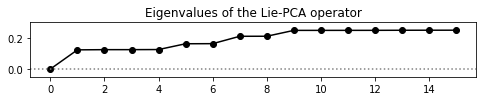

----> Optimization problem via NormalForm for torus group <----
Number of frequencies to test: 31
The optimal frequencies found is ((2, 3),) with cost 0.00016885060243895933
Optimal frequencies found: ((2, 3),)
Symmetric Hausdorff distance: 0.02859


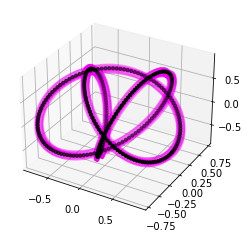

In [22]:
PrintCovarianceEigenvalues(X)
PlotNormsDistribution(X); plt.title('Distribution of norms before orthonormalization');

# Reduce dimension and orthonormalize
ambient_dim = 4
pca = sklearn.decomposition.PCA(n_components=ambient_dim)
Y = pca.fit_transform(X)
Y, Cov = Orthonormalize(Y)
PlotNormsDistribution(Y); plt.title('Distribution of norms after orthonormalization');

# Lie-PCA
Sigma = GetLiePCAOperator(Y,n_neighbors=2,dim=1,method='localPCA',verbose=0)
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

# LieDetect
frequency_max = 10
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group='torus', Sigma=Sigma, dim=1, ambient_dim=ambient_dim,
                                                              frequency_max=frequency_max, method='NormalForm', verbosity=1)            
print('Optimal frequencies found:', OptimalFrequencies)
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=N_points_subsample, x=Y[0,:], method='uniform')
print('Symmetric Hausdorff distance:', round(max(scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0],scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]),5))

# Plot estimated orbit
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
pca_Y = sklearn.decomposition.PCA(n_components=3).fit(Y)
Ypca = pca_Y.transform(Y); ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=10);
Orbitpca = pca_Y.transform(Orbit); ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=10, alpha=0.05,marker="3");
fig.savefig('Figures/Harmonic_oscillator_2.png',dpi=fig.dpi,bbox_inches='tight');